In [1]:
# Q sensitivity to P/T
# CTSM simulation vs CAMELS Obs

# Reference:
# Lehner, F., Wood, A. W., Vano, J. A., Lawrence, D. M., Clark, M. P., & Mankin, J. S. (2019).
# The potential to reduce uncertainty in regional runoff projections from climate models.
# Nature Climate Change, 9(12), 926–933. https://doi.org/10.1038/s41558-019-0639-x


import numpy as np
import pandas as pd
import statsmodels.api as sm
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from scipy.optimize import curve_fit
from shapely.geometry import Polygon, box
import geopandas as gpd
import os, scipy
import cftime

import warnings
warnings.filterwarnings('ignore')

def Q_sensitivity_to_P_T(dQ, dP, dT, conflevel=0.10):

    # Sample data
    data = {'dQ':dQ, 'dP': dP, 'dT':dT}

    df = pd.DataFrame(data)
    df['dPdT'] = df['dP'] * df['dT']

    # Define independent variables (X) and dependent variable (y)
    X = df[['dP', 'dT', 'dPdT']]
    X = sm.add_constant(X)  # Adds a constant column for the intercept
    y = df['dQ']

    # Perform regression
    model = sm.OLS(y, X).fit()

    # get coefficients
    a = model.params['dP']
    b = model.params['dT']
    c = model.params['dPdT']

    # print(f"a (coefficient for dP) = {a}")
    # print(f"b (coefficient for dT) = {b}")
    # print(f"c (coefficient for dPdT) = {c}")

    # Get the confidence intervals
    conf_intervals = model.conf_int(alpha = conflevel)  # 10% significance level for 5-95% CIs

    # Extract the intervals for dP (a) and dT (b)
    a_interval = conf_intervals.loc['dP'].values
    b_interval = conf_intervals.loc['dT'].values
    c_interval = conf_intervals.loc['dPdT'].values

    # print("Confidence interval for a (dP):", a_interval)
    # print("Confidence interval for b (dT):", b_interval)
    # print("Confidence interval for c (dPdT):", c_interval)

    return a, b, c, a_interval, b_interval, c_interval


def load_and_fill_missing_dates_CAMELSforcing(file):
    df = pd.read_csv(file, skiprows=3, delim_whitespace=True)
    df = df.rename(columns={'Year':'year', 'Mnth':'month', 'Day':'day', 'Hr':'hour'})
    df['date'] = pd.to_datetime(df[['year', 'month', 'day']])

    df.set_index('date', inplace=True)
    date_range = pd.date_range(start='1980-01-01', end='2014-12-31', freq='D')
    df_reindexed = df.reindex(date_range)
    df_reset = df_reindexed.reset_index().rename(columns={'index': 'date'})
    
    return df_reset


def load_and_fill_missing_dates_CAMELSq(file_q):
    df_q = pd.read_csv(file_q, delim_whitespace=True, header=None)
    df_q.columns = ['name', 'year', 'month', 'day', 'Qobs', 'code']
    df_q['date'] = pd.to_datetime(df_q[['year', 'month', 'day']])
    q = df_q['Qobs'].values
    q[q<0] = np.nan
    df_q['Qobs'] = q

    df_q.set_index('date', inplace=True)
    date_range = pd.date_range(start='1980-01-01', end='2014-12-31', freq='D')
    df_reindexed = df_q.reindex(date_range)
    df_reset = df_reindexed.reset_index().rename(columns={'index': 'date'})
    
    return df_reset


def custom_hausdorff(geom1, geom2):
    return max(geom1.hausdorff_distance(geom2), geom2.hausdorff_distance(geom1))


def find_matching_row(df, lats, lons):
    # Convert lat/lon vectors to a Polygon
    input_shape = Polygon(zip(lons, lats))

    # Compute the bounding box of the input shape
    minx, miny, maxx, maxy = input_shape.bounds

    # Filter out rows that don't intersect with the bounding box of input shape
    bbox = box(minx, miny, maxx, maxy)
    df_filtered = df[df.geometry.intersects(bbox)]

    # If no matching bounding boxes are found, return a value
    if df_filtered.empty:
        return -9999

    # Compute the two-way Hausdorff distance and get the maximum value
    # df_filtered['hausdorff'] = df_filtered.geometry.apply(lambda x: max(custom_hausdorff(x, input_shape), custom_hausdorff(input_shape, x)))
    df_filtered['hausdorff'] = df_filtered.geometry.apply(lambda x: custom_hausdorff(x, input_shape) )
    
    # Find the row with the minimum Hausdorff distance
    target_row = df_filtered[df_filtered['hausdorff'] == df_filtered['hausdorff'].min()]

    # Return the index of the target row
    return target_row.index[0]



def calculate_overlap_ratios(lats, lons, gdf):
    # Convert lat/lon vectors to a Polygon
    input_shape = Polygon(zip(lons, lats))
    input_shape_area = input_shape.area

    # Calculate the overlap area for each row in the dataframe
    overlap_areas = gdf.geometry.apply(lambda x: x.intersection(input_shape).area)

    # Calculate ratio-1 and ratio-2
    ratio_1 = overlap_areas / input_shape_area
    ratio_2 = overlap_areas / gdf.geometry.area

    # Return the minimum ratio for each row
    min_ratios = ratio_1.combine(ratio_2, min)

    return np.array(min_ratios)

# Load data

## Load CAMELS raw data
Q observation  
P/T from NLDAS or other datasets

In [2]:
# Load basin information
file_info = '/glade/campaign/cgd/tss/people/guoqiang/camels/obs_flow_met/basin_dataset_public_v1p2/basin_metadata/gauge_information.txt'

df_info = pd.read_csv(file_info, sep='\t', skiprows=1, header=None)
df_info.columns = ['HUC_02', 'GAGE_ID', 'GAGE_NAME', 'LAT', 'LONG', 'DRAINAGE_AREA_(KM^2)']
df_info = df_info.sort_values('GAGE_ID')

df_info.head()

,HUC_02,GAGE_ID,GAGE_NAME,LAT,LONG,DRAINAGE_AREA_(KM^2)
0,1,1013500,"Fish River near Fort Kent, M...",47.23739,-68.58264,2252.70
1,1,1022500,"Narraguagus River at Cherryfield, M...",44.60797,-67.93524,573.60
2,1,1030500,"Mattawamkeag River near Mattawamkeag, M...",45.50097,-68.30596,3676.17
3,1,1031500,"Piscataquis River near Dover-Foxcroft, M...",45.17501,-69.31470,769.05
4,1,1047000,"Carrabassett River near North Anson, M...",44.86920,-69.95510,909.10


In [3]:
# Load basin mean meteorological data
date_range = pd.date_range(start='1980-01-01', end='2014-12-31', freq='D') # 1980-2014 CAMELS periods
data_name = 'nldas' # daymet, maurer, nldas
pathforcing = f'/glade/campaign/cgd/tss/people/guoqiang/camels/obs_flow_met/basin_dataset_public_v1p2/basin_mean_forcing/{data_name}/all/'

tarvars = ['PRCP(mm/day)', 'SRAD(W/m2)', 'SWE(mm)', 'Tmax(C)', 'Tmin(C)', 'Vp(Pa)']
values_met = np.nan*np.zeros([len(df_info), len(date_range), len(tarvars)])

for i in range(len(df_info)):
    idi = df_info.iloc[i]['GAGE_ID']
    filei = f'{pathforcing}/{idi:08}_lump_nldas_forcing_leap.txt'
    if not os.path.isfile(filei):
        print('File does not exist:', filei)
        continue
    
    dfmet = load_and_fill_missing_dates_CAMELSforcing(filei)
    
    for j in range(len(tarvars)):
        values_met[i, :, j] = dfmet[tarvars[j]].values

In [4]:
# Load streamflow data
pathq = '/glade/campaign/cgd/tss/people/guoqiang/camels/obs_flow_met/basin_dataset_public_v1p2/usgs_streamflow/all'

values_q = np.nan*np.zeros([len(df_info), len(date_range)])

for i in range(len(df_info)):
    idi = df_info.iloc[i]['GAGE_ID']
    infilei_q = f'{pathq}/{idi:08}_streamflow_qc.txt'

    dfq = load_and_fill_missing_dates_CAMELSq(infilei_q)
    values_q[i,:] = dfq['Qobs'].values

In [5]:
# combine camels Q and met data to a xr dataset
ds_obs = xr.Dataset()
ds_obs.coords['n'] = np.arange(len(df_info))
ds_obs.coords['time'] = date_range
for j in range(len(tarvars)):
    ds_obs[tarvars[j]] = xr.DataArray(values_met[:,:,j], dims=('n', 'time'))

ds_obs['tmean'] = ( ds_obs['Tmax(C)'] + ds_obs['Tmin(C)'] ) / 2

ds_obs['Qobs'] = xr.DataArray(values_q, dims=('n', 'time'))

ds_obs['ID'] = xr.DataArray(df_info['GAGE_ID'], dims=('n'))

ds_obs

<xarray.Dataset>
Dimensions:       (n: 671, time: 12784)
Coordinates:
  * n             (n) int64 0 1 2 3 4 5 6 7 ... 663 664 665 666 667 668 669 670
  * time          (time) datetime64[ns] 1980-01-01 1980-01-02 ... 2014-12-31
Data variables:
    PRCP(mm/day)  (n, time) float64 0.0 0.0 0.0 0.0 0.0 ... 2.28 3.71 0.35 0.0
    SRAD(W/m2)    (n, time) float64 218.7 199.1 197.6 ... 188.4 291.6 245.5
    SWE(mm)       (n, time) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    Tmax(C)       (n, time) float64 -13.04 -10.93 -13.6 ... 2.65 0.89 1.67
    Tmin(C)       (n, time) float64 -13.04 -10.93 -13.6 ... 2.65 0.89 1.67
    Vp(Pa)        (n, time) float64 203.3 237.4 169.4 ... 618.7 440.0 313.1
    tmean         (n, time) float64 -13.04 -10.93 -13.6 ... 2.65 0.89 1.67
    Qobs          (n, time) float64 655.0 640.0 625.0 ... 2.46e+03 2.16e+03
    ID            (n) int64 1013500 1022500 1030500 ... 14362250 14400000

## Load CTSM simulations
Use cdo/nco to extract and merge from raw CTSM outputs, and then load the merged files


In [6]:
infile = '/glade/campaign/cgd/tss/people/guoqiang/CTSMcases/CAMELS_Calib/Calib_all_HH_Ostrich/analysis/CAMELS_DefaultSimu_QPT.nc'
ds_sim_defa = xr.load_dataset(infile)
ds_sim_defa['PRECIP'] = ds_sim_defa['RAIN'] + ds_sim_defa['SNOW']
ds_sim_defa = ds_sim_defa.squeeze()
ds_sim_defa = ds_sim_defa.rename({'hru':'n'})
if np.any(ds_sim_defa.n.values != ds_obs.ID.values):
    print('ds_sim and ds_obs HRU IDs do not match')
else:
    print('ds_sim and ds_obs HRU IDs match')

ds_sim and ds_obs HRU IDs match


In [7]:
infile = '/glade/campaign/cgd/tss/people/guoqiang/CTSMcases/CAMELS_Calib/Calib_all_HH_Ostrich/analysis/CAMELS_Bestsimu1_QPT.nc'
ds_sim_optm = xr.load_dataset(infile)
ds_sim_optm['PRECIP'] = ds_sim_optm['RAIN'] + ds_sim_optm['SNOW']
ds_sim_optm = ds_sim_optm.squeeze()
ds_sim_optm = ds_sim_optm.rename({'hru':'n'})
if np.any(ds_sim_optm.n.values != ds_obs.ID.values):
    print('ds_sim and ds_obs HRU IDs do not match')
else:
    print('ds_sim and ds_obs HRU IDs match')

ds_sim and ds_obs HRU IDs match


# Process data

## Unify the units
T: K  
P: mm/day  
Q: mm/day  

In [8]:
# for v in ['Tmax(C)', 'Tmin(C)', 'tmean']:
#     ds_obs[v] = ds_obs[v] + 273.15
    
area = df_info['DRAINAGE_AREA_(KM^2)'].values * 1e6 # m2
Qtmp = ds_obs['Qobs'].values 
for i in range(Qtmp.shape[0]):
    Qtmp[i,:] = Qtmp[i,:] * 0.0283168 * 60 * 60 * 24 / area[i] * 1000
    
ds_obs['Qobs'].values = Qtmp

In [9]:
for v in ['tmean', 'Tmin(C)', 'Tmax(C)']:
    ds_obs[v] = ds_obs[v] + 273.15

In [10]:
for v in ['RAIN', 'SNOW', 'RAIN_FROM_ATM', 'SNOW_FROM_ATM', 'PRECIP', 'QRUNOFF']:
    if v in ds_sim_defa.data_vars:
        ds_sim_defa[v] = ds_sim_defa[v] * 60 * 60 * 24
    if v in ds_sim_optm.data_vars:
        ds_sim_optm[v] = ds_sim_optm[v] * 60 * 60 * 24

## Drop Feb-29 

In [11]:
ds_obs = ds_obs.where((ds_obs['time.month'] != 2) | (ds_obs['time.day'] != 29), drop=True)

## Remove calibration periods

In [12]:
def assign_nan_to_calibperiod(ds_sim_optm, leapcheck=False):
    for n_value in ds_sim_optm['n'].values:
        # Get the corresponding calibstart and calibend dates for the current 'n'
        calibstart = ds_sim_optm['calibstart'].sel(n=n_value).values
        calibend = ds_sim_optm['calibend'].sel(n=n_value).values

        # Convert calibstart and calibend to cftime.DatetimeNoLeap if they are not already
        if leapcheck:
            
            # Convert calibstart and calibend to standard Python datetime objects
            calibstart = pd.to_datetime(calibstart).to_pydatetime()
            calibend = pd.to_datetime(calibend).to_pydatetime()
            
            if not isinstance(calibstart, cftime._cftime.DatetimeNoLeap):
                calibstart = cftime.DatetimeNoLeap(calibstart.year, calibstart.month, calibstart.day)
            if not isinstance(calibend, cftime._cftime.DatetimeNoLeap):
                calibend = cftime.DatetimeNoLeap(calibend.year, calibend.month, calibend.day)


        # Create a boolean mask for the time period between calibstart and calibend
        time_mask = (ds_sim_optm['time'].values >= calibstart) & (ds_sim_optm['time'].values <= calibend)

        # Loop through each data variable
        for var_name, variable in ds_sim_optm.data_vars.items():
            if 'time' in variable.dims and 'n' in variable.dims:
                # Apply the mask and set values to nan for the specified time period
                ds_sim_optm[var_name].loc[dict(n=n_value, time=time_mask)] = np.nan
                
    return ds_sim_optm

ds_obs['calibstart'] = xr.DataArray(ds_sim_defa['calibstart'].values, dims=('n'))
ds_obs['calibend'] = xr.DataArray(ds_sim_defa['calibend'].values, dims=('n'))
ds_obs = assign_nan_to_calibperiod(ds_obs, False)
ds_sim_defa = assign_nan_to_calibperiod(ds_sim_defa, True)
ds_sim_optm = assign_nan_to_calibperiod(ds_sim_optm, True)

## Calculate water year mean

In [13]:
month_start = 10
month_end = 9
years = [1980, 2014]

In [14]:
# CAMELS obs to water year mean
tarvar = ['Qobs', 'tmean', 'PRCP(mm/day)']

flag = 0
n1 = years[1]-years[0]
n2 = len(tarvar)

values = np.nan * np.zeros([n1, n2, len(ds_obs.n)])

for i in range(n1):
    yi = years[0] + i
    for j in range(n2):
        dij = ds_obs[tarvar[j]].sel(time=slice(f'{yi}-{month_start:02}', f'{yi+1}-{month_end:02}'))
        values[i, j] = dij.mean(dim='time').values
        
ds_obs_wy = xr.Dataset()
ds_obs_wy.coords['time'] = pd.date_range(f'{years[0]}-{month_start}', f'{years[1]}-{month_start}', freq='Y')
ds_obs_wy.coords['n'] = ds_obs.n

for i in range(n2):
    ds_obs_wy[tarvar[i]] = xr.DataArray(values[:, i, :], dims=('time', 'n'))
    ds_obs_wy[tarvar[i]].attrs = ds_obs[tarvar[i]].attrs
    
ds_obs_wy = ds_obs_wy.rename({'Qobs': 'Q', 'tmean': 'T', 'PRCP(mm/day)': 'P'})
ds_obs = ds_obs.rename({'Qobs': 'Q', 'tmean': 'T', 'PRCP(mm/day)': 'P'})

In [15]:
# CAMELS obs to water year mean
tarvar = ['TBOT', 'QRUNOFF', 'PRECIP']
n1 = years[1]-years[0]
n2 = len(tarvar)

values = np.nan * np.zeros([n1, n2, len(ds_sim_defa.n)])

for i in range(n1):
    yi = years[0] + i
    for j in range(n2):
        dij = ds_sim_defa[tarvar[j]].sel(time=slice(f'{yi}-{month_start:02}', f'{yi+1}-{month_end:02}'))
        values[i, j] = np.squeeze(dij.mean(dim='time').values)
        
ds_sim_defa_wy = xr.Dataset()
ds_sim_defa_wy.coords['time'] = pd.date_range(f'{years[0]}-{month_start}', f'{years[1]}-{month_start}', freq='Y')
ds_sim_defa_wy.coords['n'] = ds_sim_defa.n

for i in range(n2):
    ds_sim_defa_wy[tarvar[i]] = xr.DataArray(values[:, i, :], dims=('time', 'n'))
    ds_sim_defa_wy[tarvar[i]].attrs = ds_sim_defa[tarvar[i]].attrs
    
ds_sim_defa_wy = ds_sim_defa_wy.rename({'QRUNOFF': 'Q', 'TBOT': 'T', 'PRECIP': 'P',})
ds_sim_defa = ds_sim_defa.rename({'QRUNOFF': 'Q', 'TBOT': 'T', 'PRECIP': 'P',})

In [16]:
# CAMELS obs to water year mean
tarvar = ['TBOT', 'QRUNOFF', 'PRECIP']
n1 = years[1]-years[0]
n2 = len(tarvar)

values = np.nan * np.zeros([n1, n2, len(ds_sim_optm.n)])

for i in range(n1):
    yi = years[0] + i
    for j in range(n2):
        dij = ds_sim_optm[tarvar[j]].sel(time=slice(f'{yi}-{month_start:02}', f'{yi+1}-{month_end:02}'))
        values[i, j] = np.squeeze(dij.mean(dim='time').values)
        
ds_sim_optm_wy = xr.Dataset()
ds_sim_optm_wy.coords['time'] = pd.date_range(f'{years[0]}-{month_start}', f'{years[1]}-{month_start}', freq='Y')
ds_sim_optm_wy.coords['n'] = ds_sim_optm.n

for i in range(n2):
    ds_sim_optm_wy[tarvar[i]] = xr.DataArray(values[:, i, :], dims=('time', 'n'))
    ds_sim_optm_wy[tarvar[i]].attrs = ds_sim_optm[tarvar[i]].attrs
    
ds_sim_optm_wy = ds_sim_optm_wy.rename({'QRUNOFF': 'Q', 'TBOT': 'T', 'PRECIP': 'P',})
ds_sim_optm = ds_sim_optm.rename({'QRUNOFF': 'Q', 'TBOT': 'T', 'PRECIP': 'P',})

# Evaluate model performance
Monthly evaluation unless CTSM outputs are daily

In [17]:
def get_modified_KGE(obs,sim):
    sim[sim<0] = np.nan
    obs[obs<0] = np.nan
    ind = (~np.isnan(obs)) & (~np.isnan(sim))
    obs = obs[ind]
    sim = sim[ind]

    try:
        sd_sim=np.std(sim, ddof=1)
        sd_obs=np.std(obs, ddof=1)
        m_sim=np.mean(sim)
        m_obs=np.mean(obs)
        r=(np.corrcoef(sim,obs))[0,1]
        relvar=(float(sd_sim)/float(m_sim))/(float(sd_obs)/float(m_obs))
        bias=float(m_sim)/float(m_obs)
        kge=1.0-np.sqrt((r-1)**2 +(relvar-1)**2 + (bias-1)**2)
    except:
        kge = np.nan

    return kge, r, relvar, bias


def get_RMSE(obs,sim):
    sim[sim<0] = np.nan
    obs[obs<0] = np.nan
    rmse = np.sqrt(np.nanmean(np.power((sim - obs),2)))
    return rmse

def get_mean_error(obs,sim):
    bias_err = np.nanmean(sim - obs)
    abs_err = np.nanmean(np.absolute(sim - obs))
    return bias_err, abs_err

In [18]:

metric_defa_values = np.nan * np.zeros([ len(ds_obs.n), 5])
metric_optm_values = np.nan * np.zeros([ len(ds_obs.n), 5])

period = [1980, 2013]
for i in range(len(ds_obs.n)):
    qobs = ds_obs['Q'].isel(n=i).sel(time=slice(str(period[0]), str(period[1]))).resample(time='1M').mean().values
    qsim = ds_sim_defa['Q'].isel(n=i).sel(time=slice(str(period[0]), str(period[1]))).values
    metric_defa_values[i, :4] = get_modified_KGE(qobs, qsim)
    metric_defa_values[i, 4] = get_RMSE(qobs, qsim)
    
    qsim = ds_sim_optm['Q'].isel(n=i).sel(time=slice(str(period[0]), str(period[1]))).values
    metric_optm_values[i, :4] = get_modified_KGE(qobs, qsim)
    metric_optm_values[i, 4] = get_RMSE(qobs, qsim)

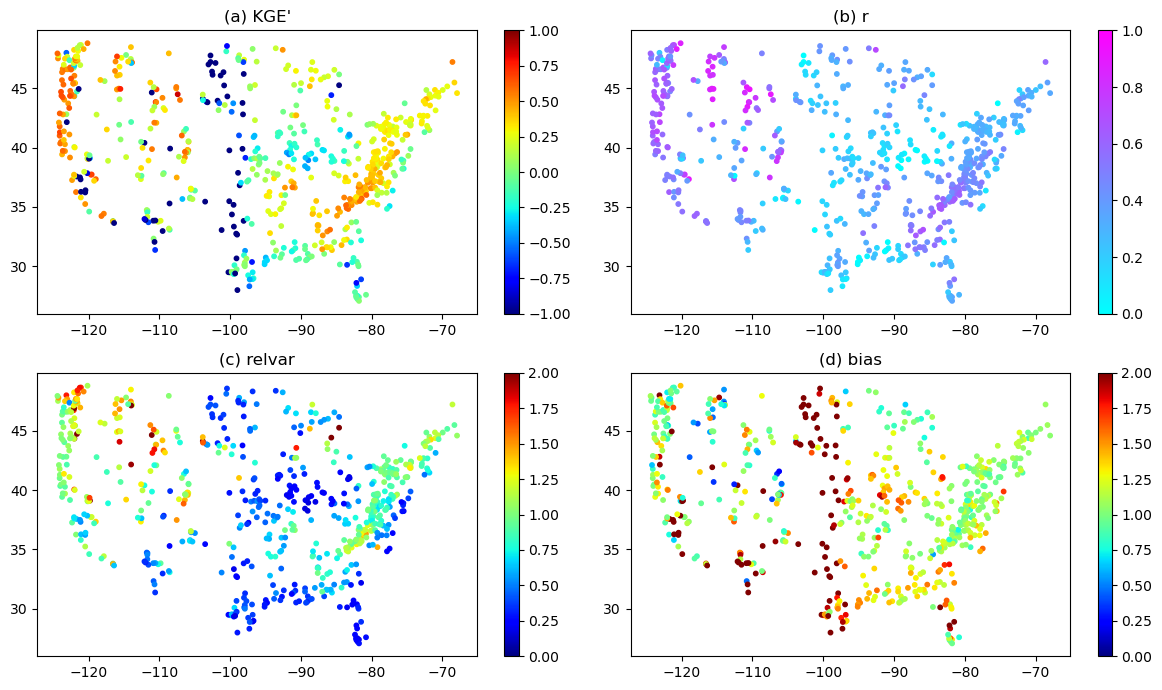

In [19]:
# default param metrics:

lat = df_info['LAT'].values
lon = df_info['LONG'].values

titles = ["(a) KGE'", '(b) r', '(c) relvar', '(d) bias']
vminvmax = [ [-1, 1], [0, 1], [0, 2], [0, 2] ]
# cmaps = ['cool', 'cool', 'PiYG', 'PiYG']
cmaps = ['jet', 'cool', 'jet', 'jet']

fig, axs = plt.subplots(2, 2, figsize=[12, 7])
axs = axs.flatten()

for i in range(4):
    ax = axs[i]
    p = ax.scatter(lon, lat, 10, metric_defa_values[:,i], cmap=cmaps[i], vmin=vminvmax[i][0], vmax=vminvmax[i][1], )
    plt.colorbar(p, ax=ax)
    ax.set_title(titles[i])

plt.tight_layout()
plt.show()

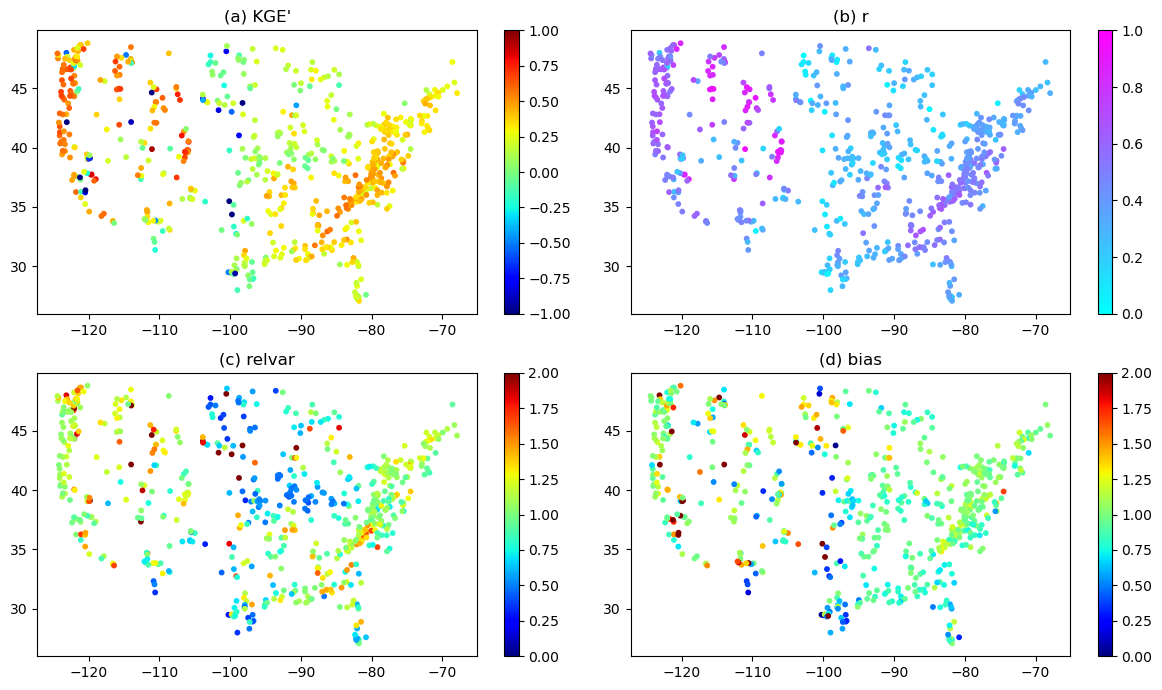

In [20]:
# optimized param metrics:

lat = df_info['LAT'].values
lon = df_info['LONG'].values

titles = ["(a) KGE'", '(b) r', '(c) relvar', '(d) bias']
vminvmax = [ [-1, 1], [0, 1], [0, 2], [0, 2] ]
# cmaps = ['cool', 'cool', 'PiYG', 'PiYG']
cmaps = ['jet', 'cool', 'jet', 'jet']

fig, axs = plt.subplots(2, 2, figsize=[12, 7])
axs = axs.flatten()

for i in range(4):
    ax = axs[i]
    p = ax.scatter(lon, lat, 10, metric_optm_values[:,i], cmap=cmaps[i], vmin=vminvmax[i][0], vmax=vminvmax[i][1], )
    plt.colorbar(p, ax=ax)
    ax.set_title(titles[i])

plt.tight_layout()
plt.show()

# Calculate sensitivity

In [21]:
# period = [1950, 2000]
period = [1980, 2013]

In [22]:
# observation

nb = len(df_info)
obs_dQ_v_dT = np.nan * np.zeros(nb)
obs_dQ_v_dP = np.nan * np.zeros(nb)
obs_dQ_v_dPdT = np.nan * np.zeros(nb)

obs_dQ_v_dT_range = np.nan * np.zeros([nb, 2])
obs_dQ_v_dP_range = np.nan * np.zeros([nb, 2])
obs_dQ_v_dPdT_range = np.nan * np.zeros([nb, 2])


for i in range(nb):
    Q = ds_obs_wy['Q'].sel(time=slice(str(period[0]), str(period[1]))).isel(n=i).values
    # P = ds_obs_wy['P'].sel(time=slice(str(period[0]), str(period[1]))).isel(n=i).values
    # T = ds_obs_wy['T'].sel(time=slice(str(period[0]), str(period[1]))).isel(n=i).values
    P = ds_sim_optm_wy['P'].sel(time=slice(str(period[0]), str(period[1]))).isel(n=i).values
    T = ds_sim_optm_wy['T'].sel(time=slice(str(period[0]), str(period[1]))).isel(n=i).values
    
    indi = ~np.isnan(Q+P+T)
    if np.sum(indi)/len(indi)<0.6:
        print('Warning! Invalid ratio >0.8')
    Q, P, T = Q[indi], P[indi], T[indi]
    
    dQ = (Q - np.mean(Q)) / np.mean(Q) * 100
    dP = (P - np.mean(P)) / np.mean(P) * 100
    dT = T - np.mean(T)
    
    a, b, c, a_interval, b_interval, c_interval = Q_sensitivity_to_P_T(dQ, dP, dT, conflevel=0.10)
    obs_dQ_v_dP[i] = a
    obs_dQ_v_dT[i] = b
    obs_dQ_v_dPdT[i] = c
    obs_dQ_v_dP_range[i] = a_interval
    obs_dQ_v_dT_range[i] = b_interval
    obs_dQ_v_dPdT_range[i] = c_interval


Warning! Invalid ratio >0.8
Warning! Invalid ratio >0.8
Warning! Invalid ratio >0.8
Warning! Invalid ratio >0.8
Warning! Invalid ratio >0.8
Warning! Invalid ratio >0.8
Warning! Invalid ratio >0.8
Warning! Invalid ratio >0.8
Warning! Invalid ratio >0.8
Warning! Invalid ratio >0.8
Warning! Invalid ratio >0.8
Warning! Invalid ratio >0.8


In [23]:
# simulation: default

nb = len(ds_sim_defa_wy.n)
sim_defa_dQ_v_dT = np.nan * np.zeros(nb)
sim_defa_dQ_v_dP = np.nan * np.zeros(nb)
sim_defa_dQ_v_dPdT = np.nan * np.zeros(nb)

sim_defa_dQ_v_dT_range = np.nan * np.zeros([nb, 2])
sim_defa_dQ_v_dP_range = np.nan * np.zeros([nb, 2])
sim_defa_dQ_v_dPdT_range = np.nan * np.zeros([nb, 2])


for i in range(nb):
    Q = ds_sim_defa_wy['Q'].sel(time=slice(str(period[0]), str(period[1]))).isel(n=i).values.copy()
    P = ds_sim_optm_wy['P'].sel(time=slice(str(period[0]), str(period[1]))).isel(n=i).values
    T = ds_sim_optm_wy['T'].sel(time=slice(str(period[0]), str(period[1]))).isel(n=i).values
    
    Q2 = ds_obs_wy['Q'].sel(time=slice(str(period[0]), str(period[1]))).isel(n=i).values
    Q[np.isnan(Q2)] = np.nan
    
    indi = ~np.isnan(Q+P+T)
    if np.sum(indi)/len(indi)<0.6:
        print('Warning! Invalid ratio >0.8')
    Q, P, T = Q[indi], P[indi], T[indi]
    
    dQ = (Q - np.mean(Q)) / np.mean(Q) * 100
    dP = (P - np.mean(P)) / np.mean(P) * 100
    dT = T - np.mean(T)
    
    a, b, c, a_interval, b_interval, c_interval = Q_sensitivity_to_P_T(dQ, dP, dT, conflevel=0.10)
    sim_defa_dQ_v_dP[i] = a
    sim_defa_dQ_v_dT[i] = b
    sim_defa_dQ_v_dPdT[i] = c
    sim_defa_dQ_v_dP_range[i] = a_interval
    sim_defa_dQ_v_dT_range[i] = b_interval
    sim_defa_dQ_v_dPdT_range[i] = c_interval

Warning! Invalid ratio >0.8
Warning! Invalid ratio >0.8
Warning! Invalid ratio >0.8
Warning! Invalid ratio >0.8
Warning! Invalid ratio >0.8
Warning! Invalid ratio >0.8
Warning! Invalid ratio >0.8
Warning! Invalid ratio >0.8
Warning! Invalid ratio >0.8
Warning! Invalid ratio >0.8
Warning! Invalid ratio >0.8
Warning! Invalid ratio >0.8


In [24]:
# simulation: optmized

nb = len(ds_sim_optm_wy.n)
sim_optm_dQ_v_dT = np.nan * np.zeros(nb)
sim_optm_dQ_v_dP = np.nan * np.zeros(nb)
sim_optm_dQ_v_dPdT = np.nan * np.zeros(nb)

sim_optm_dQ_v_dT_range = np.nan * np.zeros([nb, 2])
sim_optm_dQ_v_dP_range = np.nan * np.zeros([nb, 2])
sim_optm_dQ_v_dPdT_range = np.nan * np.zeros([nb, 2])


for i in range(nb):
    Q = ds_sim_optm_wy['Q'].sel(time=slice(str(period[0]), str(period[1]))).isel(n=i).values.copy()
    P = ds_sim_optm_wy['P'].sel(time=slice(str(period[0]), str(period[1]))).isel(n=i).values
    T = ds_sim_optm_wy['T'].sel(time=slice(str(period[0]), str(period[1]))).isel(n=i).values
    
    Q2 = ds_obs_wy['Q'].sel(time=slice(str(period[0]), str(period[1]))).isel(n=i).values
    Q[np.isnan(Q2)] = np.nan
    
    indi = ~np.isnan(Q+P+T)
    if np.sum(indi)/len(indi)<0.6:
        print('Warning! Invalid ratio >0.8')
    Q, P, T = Q[indi], P[indi], T[indi]
    
    dQ = (Q - np.mean(Q)) / np.mean(Q) * 100
    dP = (P - np.mean(P)) / np.mean(P) * 100
    dT = T - np.mean(T)
    
    a, b, c, a_interval, b_interval, c_interval = Q_sensitivity_to_P_T(dQ, dP, dT, conflevel=0.10)
    sim_optm_dQ_v_dP[i] = a
    sim_optm_dQ_v_dT[i] = b
    sim_optm_dQ_v_dPdT[i] = c
    sim_optm_dQ_v_dP_range[i] = a_interval
    sim_optm_dQ_v_dT_range[i] = b_interval
    sim_optm_dQ_v_dPdT_range[i] = c_interval

Warning! Invalid ratio >0.8
Warning! Invalid ratio >0.8
Warning! Invalid ratio >0.8
Warning! Invalid ratio >0.8
Warning! Invalid ratio >0.8
Warning! Invalid ratio >0.8
Warning! Invalid ratio >0.8
Warning! Invalid ratio >0.8
Warning! Invalid ratio >0.8
Warning! Invalid ratio >0.8
Warning! Invalid ratio >0.8
Warning! Invalid ratio >0.8


# Plot sensitivities

## Plot spatial maps

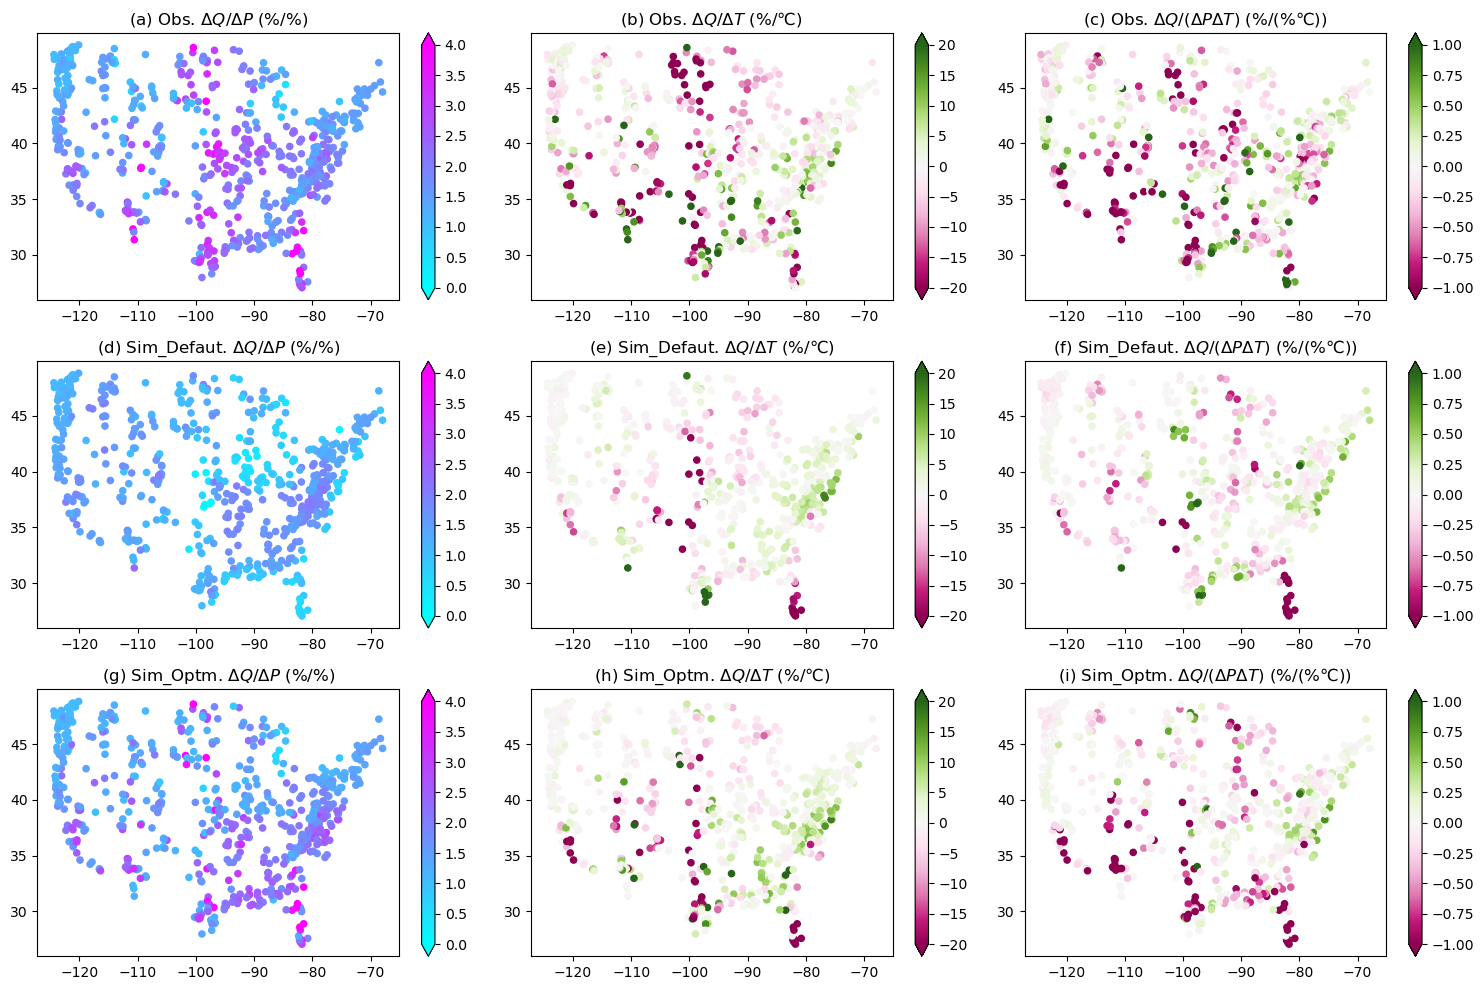

In [25]:
# spatial map

dataplot = [ [obs_dQ_v_dP, obs_dQ_v_dT, obs_dQ_v_dPdT], 
             [sim_defa_dQ_v_dP, sim_defa_dQ_v_dT, sim_defa_dQ_v_dPdT], 
             [sim_optm_dQ_v_dP, sim_optm_dQ_v_dT, sim_optm_dQ_v_dPdT], 
             ]

vminvmax = [ [[0, 4], [-20, 20], [-1, 1]], 
             [[0, 4], [-20, 20], [-1, 1]],
             [[0, 4], [-20, 20], [-1, 1]] ] 
cmaps = [ ['cool', 'PiYG', 'PiYG'], 
          ['cool', 'PiYG', 'PiYG'],
          ['cool', 'PiYG', 'PiYG'] ]
 

lat = df_info['LAT'].values
lon = df_info['LONG'].values
titles = [ [r"(a) Obs. $\Delta Q /\Delta P$ (%/%)", r"(b) Obs. $\Delta Q /\Delta T$ (%/℃)", r"(c) Obs. $\Delta Q /(\Delta P \Delta T)$ (%/(%℃))"], 
           [r"(d) Sim_Defaut. $\Delta Q /\Delta P$ (%/%)", r"(e) Sim_Defaut. $\Delta Q /\Delta T$ (%/℃)", r"(f) Sim_Defaut. $\Delta Q /(\Delta P \Delta T)$ (%/(%℃))"],
          [r"(g) Sim_Optm. $\Delta Q /\Delta P$ (%/%)", r"(h) Sim_Optm. $\Delta Q /\Delta T$ (%/℃)", r"(i) Sim_Optm. $\Delta Q /(\Delta P \Delta T)$ (%/(%℃))"] ]

fig, axs = plt.subplots(3, 3, figsize=[15, 10])

for i in range(3):
    for j in range(3):
        ax = axs[i, j]
        
        p = ax.scatter(lon, lat, 20, dataplot[i][j], cmap=cmaps[i][j], vmin=vminvmax[i][j][0], vmax=vminvmax[i][j][1])
        ax.set_title(titles[i][j])

        plt.colorbar(p, ax=ax, extend='both')
        
        # Upper colorado
#         ax.set_ylim([37, 41])
#         ax.set_xlim([-109, -102])
        
    
plt.tight_layout()
# plt.show()
plt.savefig('Sensitivity_map.png', dpi=600, facecolor='w', bbox_inches='tight',pad_inches = 0)


## Plot confidence invervobs_dQ_v_dPals
Note basins are sorted from low to high sensitivities. Sim and Obs are sorted separately. 

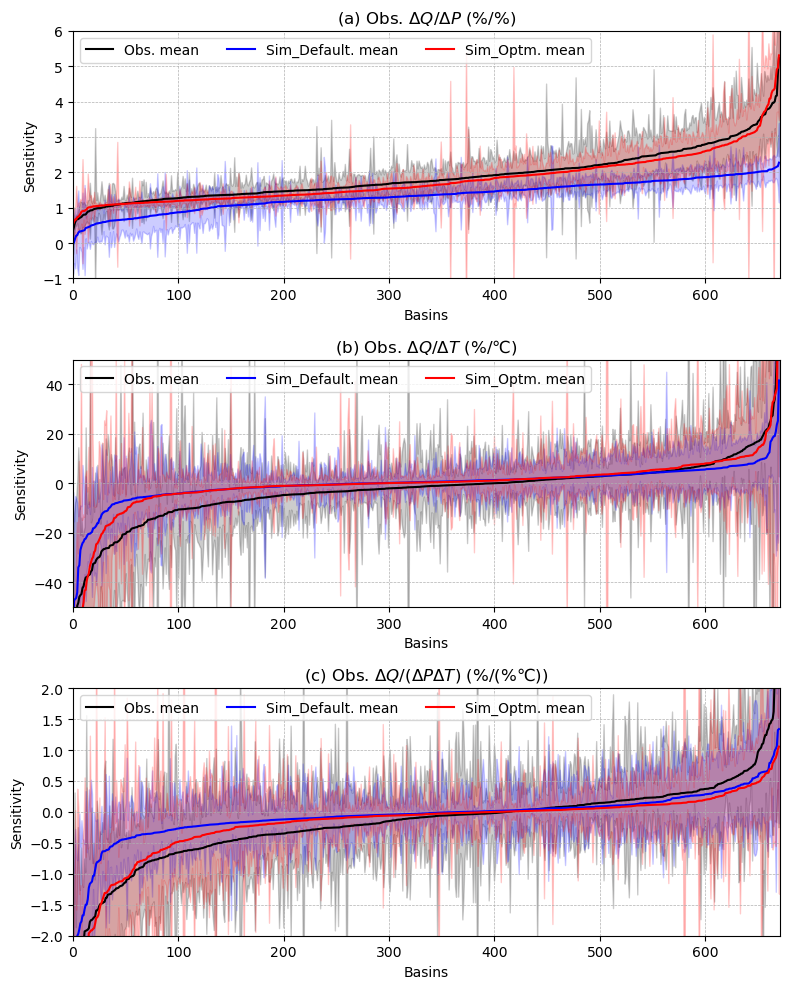

In [26]:
# curve: type-2, obs and sim in same figure

dataplot = [ [obs_dQ_v_dP, obs_dQ_v_dT, obs_dQ_v_dPdT], 
             [sim_defa_dQ_v_dP, sim_defa_dQ_v_dT, sim_defa_dQ_v_dPdT], 
             [sim_optm_dQ_v_dP, sim_optm_dQ_v_dT, sim_optm_dQ_v_dPdT], 
             ]

datarangeplot = [ [obs_dQ_v_dP_range, obs_dQ_v_dT_range, obs_dQ_v_dPdT_range], 
             [sim_defa_dQ_v_dP_range, sim_defa_dQ_v_dT_range, sim_defa_dQ_v_dPdT_range], 
             [sim_optm_dQ_v_dP_range, sim_optm_dQ_v_dT_range, sim_optm_dQ_v_dPdT_range], 
             ]


vminvmax = [ [[-1, 6], [-50, 50], [-2, 2]], 
             [[-1, 6], [-50, 50], [-2, 2]] ] 


fig, axs = plt.subplots(3, 1, figsize=[8, 10])

for i in range(3):
    for j in range(1):
        ax = axs[i]
        
        #obs
        data = dataplot[0][i]
        data_range = datarangeplot[0][i]

        sorted_indices = np.argsort(data)
        sorted_data = data[sorted_indices]
        sorted_data_range = data_range[sorted_indices]

        ax.plot(range(len(sorted_data)), sorted_data, label="Obs. mean", color='black')
        ax.fill_between(range(len(sorted_data)), 
                         sorted_data_range[:, 0], 
                         sorted_data_range[:, 1], 
                         color='black', alpha=0.2) #, label="Obs. 5-95%")
        
        #sim default
        data = dataplot[1][i]
        data_range = datarangeplot[1][i]

        sorted_indices = np.argsort(data)
        sorted_data = data[sorted_indices]
        sorted_data_range = data_range[sorted_indices]

        ax.plot(range(len(sorted_data)), sorted_data, label="Sim_Default. mean", color='blue')
        ax.fill_between(range(len(sorted_data)), 
                         sorted_data_range[:, 0], 
                         sorted_data_range[:, 1], 
                         color='blue', alpha=0.2) #, label="Sim_Default. 5-95%")
        
        #sim optmization
        data = dataplot[2][i]
        data_range = datarangeplot[2][i]

        sorted_indices = np.argsort(data)
        sorted_data = data[sorted_indices]
        sorted_data_range = data_range[sorted_indices]

        ax.plot(range(len(sorted_data)), sorted_data, label="Sim_Optm. mean", color='red')
        ax.fill_between(range(len(sorted_data)), 
                         sorted_data_range[:, 0], 
                         sorted_data_range[:, 1], 
                         color='red', alpha=0.2) #, label="Sim_Optm. 5-95%")

        ax.set_title(titles[0][i])
        ax.set_xlabel("Basins")
        ax.set_ylabel("Sensitivity")
        ax.grid(True, which='both', linestyle='--', linewidth=0.5)
        
        
        ax.legend(loc='upper left', ncol=4)
        ax.set_ylim(vminvmax[0][i])
        ax.set_xlim(0, len(data))

plt.tight_layout()
# plt.show()
plt.savefig('Sensitivity_CDF.png', dpi=600, facecolor='w', bbox_inches='tight',pad_inches = 0)

## scatter plots

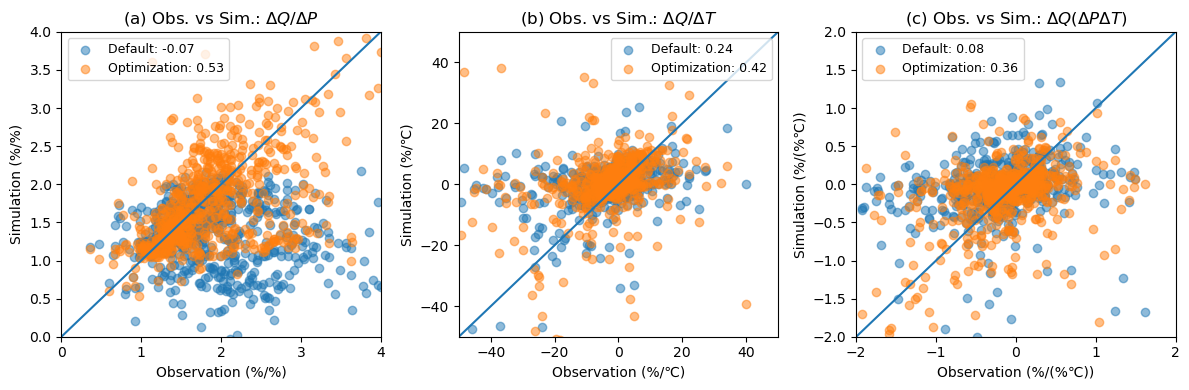

In [30]:
# scatter-1

dataplot = [ [obs_dQ_v_dP, obs_dQ_v_dT, obs_dQ_v_dPdT], 
             [sim_defa_dQ_v_dP, sim_defa_dQ_v_dT, sim_defa_dQ_v_dPdT], 
             [sim_optm_dQ_v_dP, sim_optm_dQ_v_dT, sim_optm_dQ_v_dPdT], 
             ]

vminvmax = [ [0, 4], [-50, 50], [-2, 2] ] 
units = ['(%/%)', '(%/℃)', '(%/(%℃))']


lat = df_info['LAT'].values
lon = df_info['LONG'].values
titles = [ r"(a) Obs. vs Sim.: $\Delta Q /\Delta P$", r"(b) Obs. vs Sim.: $\Delta Q /\Delta T$", r"(c) Obs. vs Sim.: $\Delta Q (\Delta P \Delta T)$" ]

fig, axs = plt.subplots(1, 3, figsize=[12, 4])

for i in range(3):
    ax = axs[i]
        
    ax.scatter(dataplot[0][i], dataplot[1][i], alpha=0.5, label='Default')
    
    ax.scatter(dataplot[0][i], dataplot[2][i], alpha=0.5, label='Optimization')
    
    ax.plot(vminvmax[i], vminvmax[i])
    
    ax.set_title(titles[i])
    
    ax.set_xlim(vminvmax[i])
    ax.set_ylim(vminvmax[i])
    
    ax.set_xlabel('Observation '+units[i])
    ax.set_ylabel('Simulation '+units[i])
    
    cc1 = np.corrcoef(dataplot[0][i], dataplot[1][i])[0,1]
    cc2 = np.corrcoef(dataplot[0][i], dataplot[2][i])[0,1]
    cct = [f'Default: {cc1:.2f}', f'Optimization: {cc2:.2f}']
    
    ax.legend(cct, frameon=True, fontsize=9)
    
    
    
plt.tight_layout()
# plt.show()
plt.savefig('Sensitivity_scatter.png', dpi=600, facecolor='w', bbox_inches='tight',pad_inches = 0)

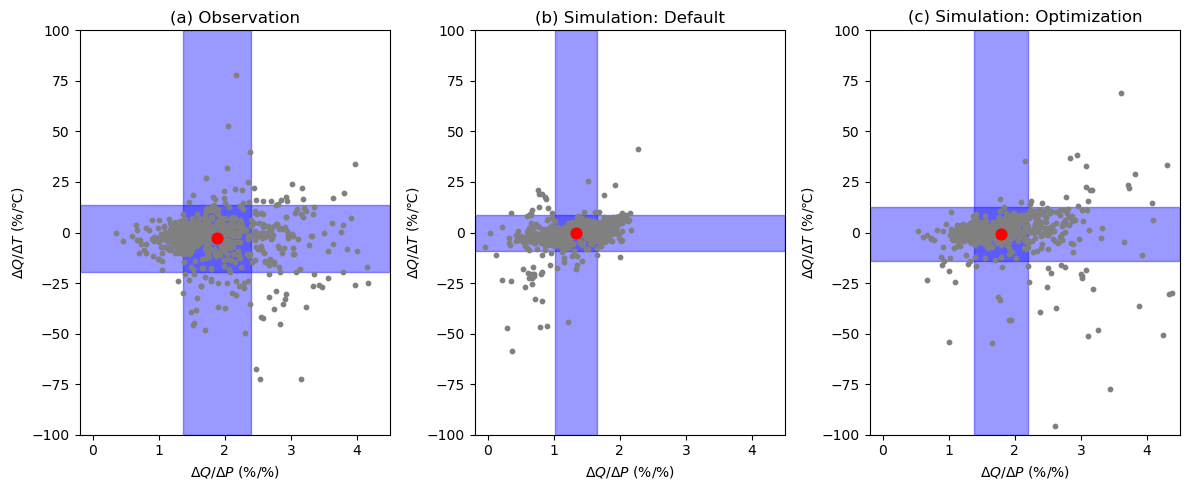

In [28]:
# scatter-2: 
xsc = [obs_dQ_v_dP, sim_defa_dQ_v_dP, sim_optm_dQ_v_dP]
ysc = [obs_dQ_v_dT, sim_defa_dQ_v_dT, sim_optm_dQ_v_dT]
xplot = [np.nanmean(obs_dQ_v_dP), np.nanmean(sim_defa_dQ_v_dP), np.nanmean(sim_optm_dQ_v_dP)]
yplot = [np.nanmean(obs_dQ_v_dT), np.nanmean(sim_defa_dQ_v_dT), np.nanmean(sim_optm_dQ_v_dT)]
xrangeplot = [ np.nanmean(obs_dQ_v_dP_range, axis=0),  np.nanmean(sim_defa_dQ_v_dP_range, axis=0),  np.nanmean(sim_optm_dQ_v_dP_range, axis=0)]
yrangeplot = [ np.nanmean(obs_dQ_v_dT_range, axis=0), np.nanmean(sim_defa_dQ_v_dT_range, axis=0), np.nanmean(sim_optm_dQ_v_dT_range, axis=0) ]

titles = ['(a) Observation', '(b) Simulation: Default', '(c) Simulation: Optimization']

xlim = [-0.2, 4.5]
ylim = [-100, 100]

fig, axs = plt.subplots(1, 3, figsize=[12, 5])

for i in range(3):
    ax = axs[i]
    
    # plt.fill_between(xrange, [yrange[0], yrange[0]], [yrange[1], yrange[1]], color='b', alpha=0.4)
    ax.fill_between(xrangeplot[i], [ylim[0], ylim[0]], [ylim[1], ylim[1]], color='b', alpha=0.4)
    ax.fill_between(xlim, [yrangeplot[i][0], yrangeplot[i][0]], [yrangeplot[i][1], yrangeplot[i][1]], color='b', alpha=0.4)
    ax.scatter(xsc[i], ysc[i], 10, color='grey')
    ax.scatter(xplot[i], yplot[i], 60, color='r')
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_ylabel(r"$\Delta Q /\Delta T $ (%/℃)")
    ax.set_xlabel(r"$\Delta Q /\Delta P$ (%/%)")
    ax.set_title(titles[i])

plt.tight_layout()
# plt.show()
plt.savefig('Sensitivity_scatter2.png', dpi=600, facecolor='w', bbox_inches='tight',pad_inches = 0)